In [1]:
#Remember to restart runtime after installation
!pip install scvi-tools --quiet
!pip install pynndescent --quiet
!pip install scanpy --quiet
!pip install leidenalg --quiet
!pip install pygments==2.14.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 351.5/351.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 61.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import anndata
import scvi
import scanpy as sc
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import warnings

# Define directory locations (Change according to folder structure preferred)
mainDir = r"drive/MyDrive/Isaac_Ang_Shared_Folder/" #change this line to your folder structure
dataDir = ''.join([mainDir, 'data/'])
rawDir = ''.join([dataDir, 'raw/'])
processedDir = ''.join([dataDir, 'processed/'])

# Set settings
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 1
sc.set_figure_params(figsize=(6,6), frameon=False)
sc.settings.n_jobs=2
sc.settings.figdir = ''.join([mainDir, 'figures/'])

INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [2]:
#%% Load data
tabula_file = ''.join([rawDir, 'TS_norm_log1p_epithelial_glyco.h5ad'])
tabula = sc.read_h5ad(tabula_file)

#Filter cells
tabula = tabula[tabula.obs['assay']=='10x 3\' v3'] #Get cells from 10X assay
sc.pp.filter_cells(tabula, min_genes = 10) 

/usr/local/lib/python3.8/dist-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [16]:
#Remove vasculature and skin
tabula = tabula[~tabula.obs['tissue_in_publication'].isin(['Vasculature', 'Skin'])].copy()

In [25]:
tabula.obs['tissue'].value_counts()

lung                        13430
prostate gland              11730
kidney                       8127
parotid gland                7598
posterior part of tongue     6862
exocrine pancreas            6467
large intestine              5762
mammary gland                5592
trachea                      4795
submandibular gland          4158
anterior part of tongue      4050
bladder organ                3924
small intestine              3073
cornea                       2932
conjunctiva                  2070
eye                          2007
liver                        1588
cardiac atrium                756
endocrine pancreas            668
sclera                        469
retinal neural layer          324
cardiac ventricle             270
endometrium                   230
thymus                        174
myometrium                      9
Name: tissue, dtype: int64

In [18]:
scvi.model.SCVI.setup_anndata( # no batch specified
  tabula, layer = "decontXcounts"
)

In [20]:
def run_scvi(
    tabula,
    n_latent=50,
    n_layers=3,
    dropout_rate=0.1,
    dispersion="gene",
    max_epochs=100,
    batch_size=1024,
    obsm_latent_key="X_scvi",
):
  model = scvi.model.SCVI(
      tabula,
      n_latent=n_latent,
      n_layers=n_layers,
      dropout_rate=dropout_rate,
      dispersion=dispersion,
      use_layer_norm="both",
      use_batch_norm="none", 
      encode_covariates=True,
  )

  model.train(max_epochs=100, train_size=1.0, batch_size=batch_size)
  tabula.obsm[obsm_latent_key] = model.get_latent_representation(tabula)

In [21]:
#Change Runtime type to GPU for faster convergence
run_scvi(
    tabula,
    max_epochs = None, # calculates based off # cells
    n_latent = 50,
    dropout_rate = 0.1,
    dispersion = "gene-batch", # splits by batch if batch_key in setup_anndata exists
    obsm_latent_key = 'X_scvi', # store results in a new column called X_scvi
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, loss=163, v_num=1]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:17<00:00,  1.37s/it, loss=163, v_num=1]


In [22]:
sc.pp.neighbors(tabula, use_rep='X_scvi', method='umap', n_neighbors=15) # get connectivities between data points
sc.tl.umap(tabula)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


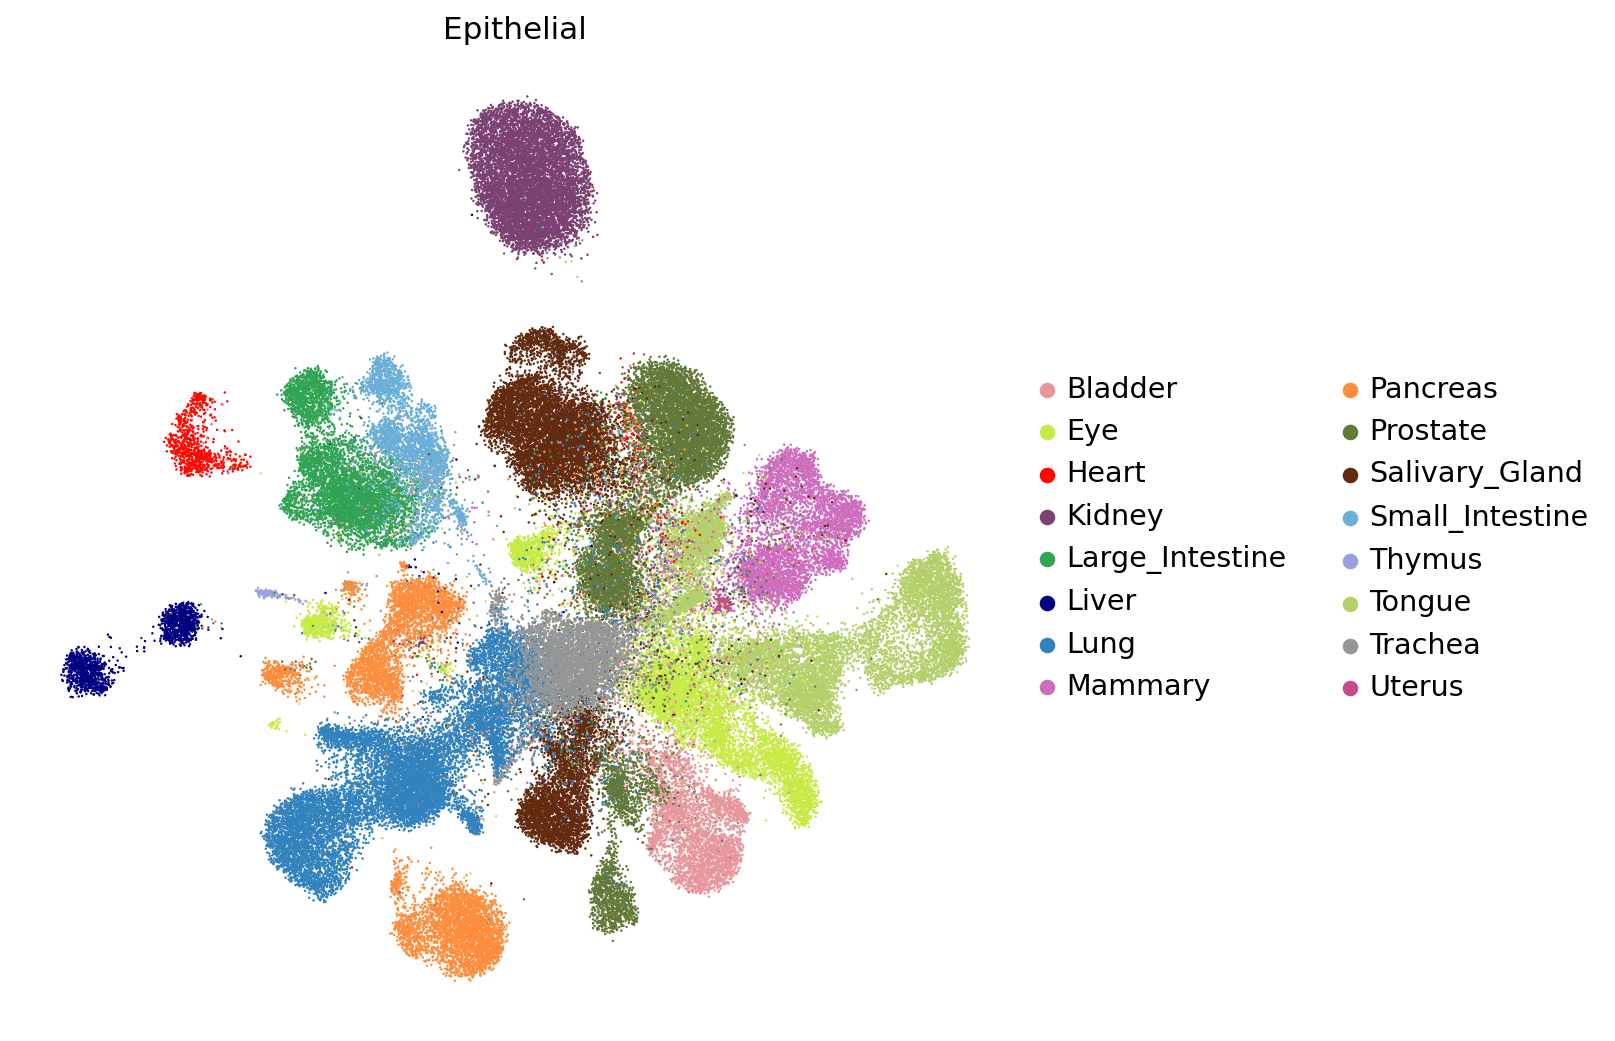

In [23]:
with rc_context({'figure.figsize': (8, 8)}):
  sc.pl.umap(tabula, color="tissue_in_publication", size=5, title = "Epithelial", save="_epithelial_10x.png")

In [24]:
tabula.write_h5ad(''.join([processedDir, 'paper/TS_scvi_epithelial_glyco.h5ad']))